In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
import sys
sys.path.append('../zdrojaky')
from tsplot import tsplot

/usr/lib/python3/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Konstrukce a odhad AR modelu

Máme k dispozici burzovní ceny akcií společnosti Google v období od 7. února 2005 do 7. července 2005. Ty jsou uloženy v souboru `googlestock.txt`, který vypadá následovně:
```
date	   price
2/7/2005    196.03
2/8/2005    198.64
2/9/2005    191.58
2/10/2005   187.98
2/11/2005   187.4
2/14/2005   192.99
```

Načtěte data z druhého sloupce do proměnné `data`, ideálně pro jednoduchost do numpy.array. Do proměnné `ndat` uložte počet měření a vykreslete řadu, ACF a PACF pomocí funkce `tsplot()`. Interpretujte, co grafy znázorňují.

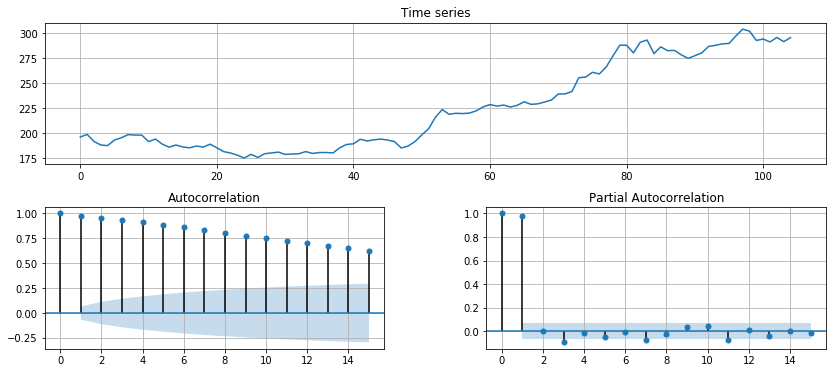

In [2]:
data = np.genfromtxt('googlestock.txt', skip_header=1, usecols=1, autostrip=True)
ndat = data.size
tsplot(data)

Vykreslete 4 grafy - scatterploty - znázorňující závislost pozorované veličiny (ceny) v čase $t$ na ceně v předchozích 4 časech $t-1$, $t-2$, $t-3$ a $t-4$. Pozor na stejná měřítka os. Interpretujte grafy, navíc s pomocí ACF a PACF. 

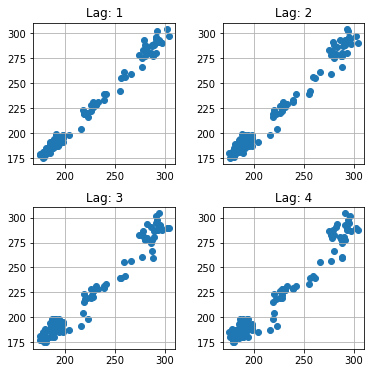

In [3]:
plt.figure(figsize=(6,6))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.scatter(data[i+1:], data[:-(i+1)])
    plt.title('Lag: {0}'.format(i+1))
    plt.axis('image')

NaFITujte mautoregresní model `AR` z balíčku `statsmodels.tsa.ar_model` na data. Je potřeba vhodně zvolit argument `maxlag`, jinak dostanete model výrazně komplikovanější. K tomu se lze propracovat kromě ACF/PACF rovněž pomocí metody `AR.select_order()`, jejíž nápovědu nalezneme rovněž níže. K dispozici máme několik kritérií IC - _information criterion_, vždy hledáme model s menší hodnotou kritéria. Oblíbená jsou:

- [AIC - Akaikeho informační kritérium](https://en.wikipedia.org/wiki/Akaike_information_criterion) - měří kvalitu FITu pomocí vztahu $AIC = 2p - 2\ln(L)$, kde $p$ je počet parametrů a $L$ je likelihood, věrohodnost fitovaných dat. Je asymptoticky ekvivalentní k leave-one-out krosvalidaci lineárních regresních modelů.
- [BIC - Bayesovské informační kritérium](https://en.wikipedia.org/wiki/Bayesian_information_criterion) - funguje podobně, akorát podle vztahu $BIC = \ln(n)k - 2\ln(L)$, kde $n$ počet dat.

In [4]:
help(AR)

Help on class AR in module statsmodels.tsa.ar_model:

class AR(statsmodels.tsa.base.tsa_model.TimeSeriesModel)
 |  Autoregressive AR(p) model
 |  
 |  Parameters
 |  ----------
 |  endog : array-like
 |      1-d endogenous response variable. The independent variable.
 |  dates : array-like of datetime, optional
 |      An array-like object of datetime objects. If a pandas object is given
 |      for endog or exog, it is assumed to have a DateIndex.
 |  freq : str, optional
 |      The frequency of the time-series. A Pandas offset or 'B', 'D', 'W',
 |      'M', 'A', or 'Q'. This is optional if dates are given.
 |  missing : str
 |      Available options are 'none', 'drop', and 'raise'. If 'none', no nan
 |      checking is done. If 'drop', any observations with nans are dropped.
 |      If 'raise', an error is raised. Default is 'none.'
 |  
 |  Method resolution order:
 |      AR
 |      statsmodels.tsa.base.tsa_model.TimeSeriesModel
 |      statsmodels.base.model.LikelihoodModel
 |   

In [5]:
model = AR(data)
order = model.select_order(maxlag=10, ic='bic', trend='c')
print('Řád AR modelu: ', order)

/usr/lib/python3/dist-packages/statsmodels/tsa/tsatools.py:612: RuntimeWarning: invalid value encountered in log
  invarcoefs = -np.log((1-params)/(1+params))
/usr/lib/python3/dist-packages/numpy/linalg/linalg.py:1817: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/usr/lib/python3/dist-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Řád AR modelu:  1


Nyní budeme FITovat :-)
Do proměnné `beta` uložte odhady (parametry) z FITu.

In [12]:
result = model.fit(maxlag=1)
beta = result.params
beta

array([-0.35845344,  1.00587089])

Zkusíme i pár predikcí budoucích hodnot, jejichž počet si předdefinujeme v proměnné `npreds`. K predikování můžeme použít jak stávající instanci `AR`, tak predikci pomocí skalárního součinu $\beta^\intercal [1, X_{t-1}]^\intercal$.

In [7]:
npreds = 100
for t in range(npreds):
    x_pred = np.dot(beta, [1, data[-1]])
    data = np.append(data, x_pred)        # Append je silně neoptimální ;-)

Vykreslíme data následovaná predikcemi.

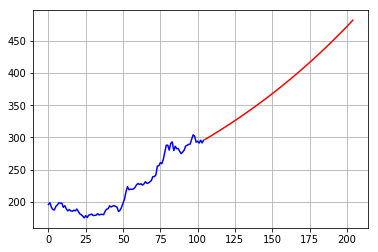

In [8]:
plt.plot(np.arange(ndat), data[:ndat], 'b')
plt.plot(np.arange(ndat, ndat+npreds), data[ndat:], 'r')

V `result.resid` najdeme rezidua regrese. Velmi užitečné je kouknout na jejich rozdělení, resp. histogram. Čekali bychom rezidua středovaná, ideálně i symetrická.

(array([ 1.,  0.,  1.,  2.,  5.,  7., 15., 19., 24., 11.,  8.,  6.,  0.,
         4.,  1.]),
 array([-14.92242189, -13.07559458, -11.22876728,  -9.38193998,
         -7.53511267,  -5.68828537,  -3.84145807,  -1.99463076,
         -0.14780346,   1.69902384,   3.54585115,   5.39267845,
          7.23950576,   9.08633306,  10.93316036,  12.77998767]),
 <a list of 15 Patch objects>)

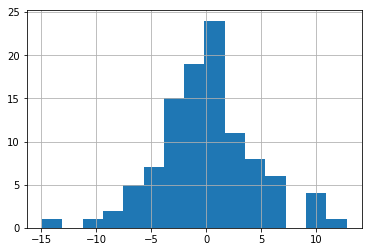

In [9]:
plt.hist(result.resid, bins=15)